In [43]:
!pip install pyspark

In [44]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler, MinMaxScaler
from pyspark.sql.types import DoubleType, IntegerType, StringType
from pyspark.sql.functions import col, sum, countDistinct, when, lit, unix_timestamp, datediff, current_date, when, round, format_number, avg, trim
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import matplotlib.pyplot as plt
import numpy as np

In [45]:
from google.colab import drive
drive.mount('/content/drive')

base_path = "/content/drive/MyDrive/Colab Notebooks/Customer Segmentation"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [46]:
import os

os.listdir(base_path)


['Customer Account.csv',
 'Customer Transaction.csv',
 'Customer Demografi.csv',
 'cust_datamart_segmentation.csv',
 'cust_datamart_trx.csv']

In [47]:
spark = SparkSession.builder \
    .appName("CustomerSegmentation") \
    .getOrCreate()

In [48]:
df = spark.read.csv("cust_datamart_segmentation.csv", header=True, inferSchema=True)

In [49]:
df.show()

+---------------+-------------+----+----------+-----------------+---------+----------+----------+--------+-------------+---------------+----------------+------------------------+
|            cif|Jenis_Kelamin|Umur|Range_Umur|Status_Pernikahan|     Gaji|Range_Gaji|Pendidikan|    Kota|Tipe_Customer|jumlah_rekening|jumlah_transaksi|jumlah_nominal_transaksi|
+---------------+-------------+----+----------+-----------------+---------+----------+----------+--------+-------------+---------------+----------------+------------------------+
|904238687894877|    Perempuan|  28|     25-34|          Married|119927317|    >100Jt|        S1| Jakarta|      Reguler|              1|               6|                31209136|
|110170787245831|    Laki-Laki|  27|     25-34|           Single| 96480811|  50-100Jt|        S1|   Medan|     Priority|              1|               3|                10291007|
|287198831176361|    Laki-Laki|  28|     25-34|           Single|111637707|    >100Jt|        S1| Bandung

In [50]:
df.count()

652

In [51]:
null_counts = df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns])
null_counts.show()

+---+-------------+----+----------+-----------------+----+----------+----------+----+-------------+---------------+----------------+------------------------+
|cif|Jenis_Kelamin|Umur|Range_Umur|Status_Pernikahan|Gaji|Range_Gaji|Pendidikan|Kota|Tipe_Customer|jumlah_rekening|jumlah_transaksi|jumlah_nominal_transaksi|
+---+-------------+----+----------+-----------------+----+----------+----------+----+-------------+---------------+----------------+------------------------+
|  0|            0|   0|         0|                0|   0|         0|         0|   0|            0|              0|               0|                       0|
+---+-------------+----+----------+-----------------+----+----------+----------+----+-------------+---------------+----------------+------------------------+



In [52]:
distinct_counts = df.select([countDistinct(col(c)).alias(c) for c in df.columns])
distinct_counts.show()

+---+-------------+----+----------+-----------------+----+----------+----------+----+-------------+---------------+----------------+------------------------+
|cif|Jenis_Kelamin|Umur|Range_Umur|Status_Pernikahan|Gaji|Range_Gaji|Pendidikan|Kota|Tipe_Customer|jumlah_rekening|jumlah_transaksi|jumlah_nominal_transaksi|
+---+-------------+----+----------+-----------------+----+----------+----------+----+-------------+---------------+----------------+------------------------+
|652|            2|  53|         5|                3| 652|         5|         5|   5|            3|              3|              65|                     652|
+---+-------------+----+----------+-----------------+----+----------+----------+----+-------------+---------------+----------------+------------------------+



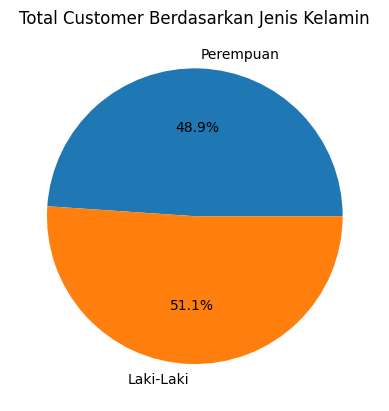

In [53]:
# 1. Hitung total customer per jenis kelamin
df_gender = df.groupBy("jenis_kelamin").count()

# 2. Convert Spark DataFrame ke list Python
data = df_gender.collect()

labels = [row['jenis_kelamin'] for row in data]
sizes = [row['count'] for row in data]

# 3. Plot pie chart
plt.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.title('Total Customer Berdasarkan Jenis Kelamin')
plt.show()

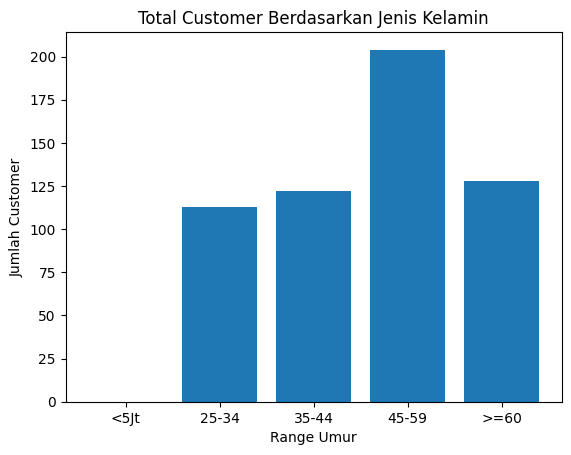

In [ ]:
# 1. Hitung total customer per Range Umur
df_umur = df.groupBy("Range_Umur").count()

# 2. Convert ke list Python (dictionary biar mudah)
data = {row['Range_Umur']: row['count'] for row in df_umur.collect()}

# 3. Tentukan urutan label yang benar
ordered_labels = ["<5Jt", "25-34", "35-44", "45-59", ">=60"]

# 4. Ambil count sesuai urutan label
sizes = [data.get(label, 0) for label in ordered_labels]

# 5. Plot bar chart
plt.bar(ordered_labels, sizes)
plt.title('Total Customer Berdasarkan Jenis Kelamin')
plt.xlabel('Range Umur')
plt.ylabel('Jumlah Customer')
plt.show()


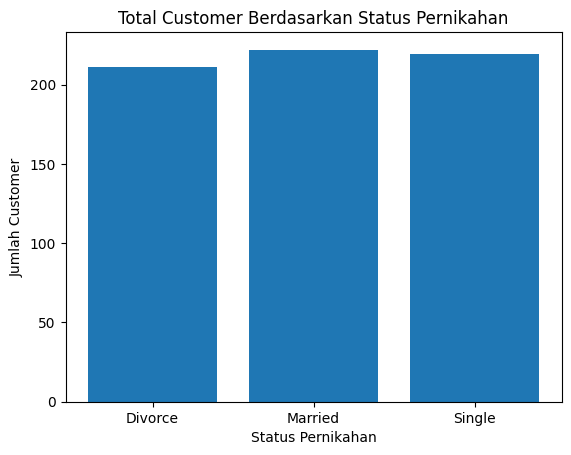

In [55]:
# 1. Hitung total customer per Status Pernikahan
df_marital_status = df.groupBy("Status_Pernikahan").count()

# 2. Convert ke list Python
data = df_marital_status.collect()

labels = [row['Status_Pernikahan'] for row in data]
sizes = [row['count'] for row in data]

# 3. Plot bar chart
plt.bar(labels, sizes)
plt.title('Total Customer Berdasarkan Status Pernikahan')
plt.xlabel('Status Pernikahan')
plt.ylabel('Jumlah Customer')
plt.show()


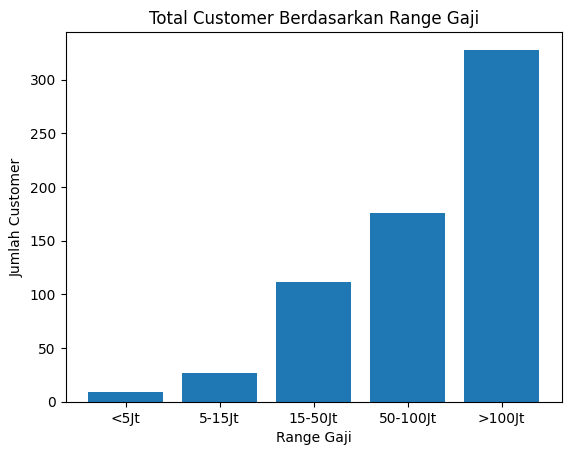

In [56]:
# 1. Hitung total customer per Range Gaji
df_gaji = df.groupBy("Range_Gaji").count()

# 2. Convert ke list Python (dictionary biar mudah)
data = {row['Range_Gaji']: row['count'] for row in df_gaji.collect()}

# 3. Tentukan urutan label yang benar
ordered_labels = ["<5Jt", "5-15Jt", "15-50Jt", "50-100Jt", ">100Jt"]

# 4. Ambil count sesuai urutan label
sizes = [data.get(label, 0) for label in ordered_labels]

# 5. Plot bar chart
plt.bar(ordered_labels, sizes)
plt.title('Total Customer Berdasarkan Range Gaji')
plt.xlabel('Range Gaji')
plt.ylabel('Jumlah Customer')
plt.show()


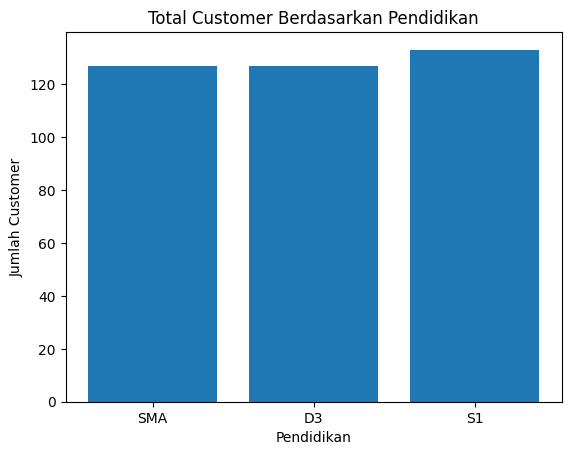

In [ ]:
# 1. Hitung total customer per Pendidikan
df_pendidikan = df.groupBy("Pendidikan").count()

# 2. Convert ke list Python (dictionary biar mudah)
data = {row['Pendidikan']: row['count'] for row in df_gaji.collect()}

# 3. Tentukan urutan label yang benar
ordered_labels = ["SMA", "D3", "S1"]

# 4. Ambil count sesuai urutan label
sizes = [data.get(label, 0) for label in ordered_labels]

# 5. Plot bar chart
plt.bar(ordered_labels, sizes)
plt.title('Total Customer Berdasarkan Pendidikan')
plt.xlabel('Pendidikan')
plt.ylabel('Jumlah Customer')
plt.show()


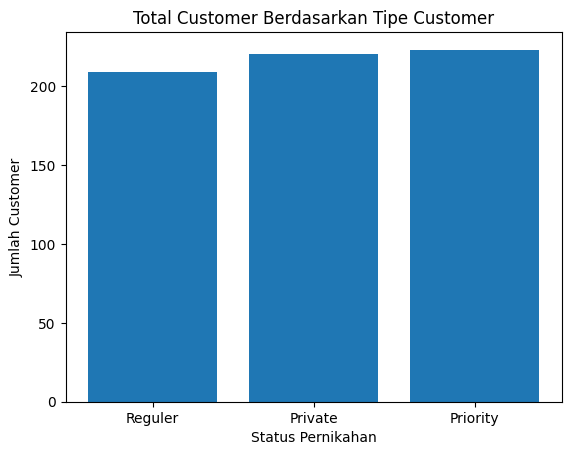

In [ ]:
# 1. Hitung total customer per Tipe Customer
df_tipe_customer = df.groupBy("Tipe_Customer").count()

# 2. Convert ke list Python
data = df_tipe_customer.collect()

labels = [row['Tipe_Customer'] for row in data]
sizes = [row['count'] for row in data]

# 3. Plot bar chart
plt.bar(labels, sizes)
plt.title('Total Customer Berdasarkan Tipe Customer')
plt.xlabel('Status Pernikahan')
plt.ylabel('Jumlah Customer')
plt.show()


In [59]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
from pyspark.ml import Pipeline

ordinal_categorical_cols = [
  "Jenis_Kelamin",
  "Status_Pernikahan",
  "Pendidikan"
]

nominal_categorical_cols = [
  "Range_Umur",
  "Range_Gaji",
  "Tipe_Customer"
]

numeric_cols = [
  "jumlah_rekening",
  "jumlah_transaksi",
  "jumlah_nominal_transaksi"
]

# 2. Preprocessing stages

# Mengubah kolom kategorikal ordinal menjadi indeks numerik
indexers = [StringIndexer(inputCol=col, outputCol=col + "_index") for col in ordinal_categorical_cols]

encoders = []
for col in nominal_categorical_cols:
    idx = StringIndexer(inputCol=col, outputCol=col + "_index") # Mengubah kolom kategorikal nominal menjadi indeks numerik
    ohe = OneHotEncoder(inputCol=col + "_index", outputCol=col + "_encoded") # Mengubah indeks numerik menjadi vektor
    encoders += [idx, ohe]

# Menggabungkan beberapa kolom numerik menjadi satu kolom berisi vektor fitur
num_assembler = VectorAssembler(inputCols=numeric_cols, outputCol="numeric_features")

# Menstandarisasi fitur numerik dengan mengurangi rata-rata (mean) dan membagi dengan standar deviasi, sehingga fitur memiliki rata-rata 0 dan varians 1
scaler = StandardScaler(inputCol="numeric_features", outputCol="numeric_scaled", withMean=True, withStd=True) # standarisasi value

# Feature akhir Daftar kolom yang akan digabungkan menjadi fitur akhir
feature_cols = [col + "_index" for col in ordinal_categorical_cols] + [col + "_encoded" for col in nominal_categorical_cols] + ["numeric_scaled"]
final_assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

# 4. Menggabungkan semua langkah preprocessing (indexers, encoders, assembler, scaler) menjadi satu alur kerja (workflow).
preprocess_pipeline = Pipeline(stages=indexers + encoders + [num_assembler, scaler, final_assembler])
df_transformed = preprocess_pipeline.fit(df).transform(df)

Text(0.5, 1.0, 'Silhouette Score for Different Numbers of Clusters')

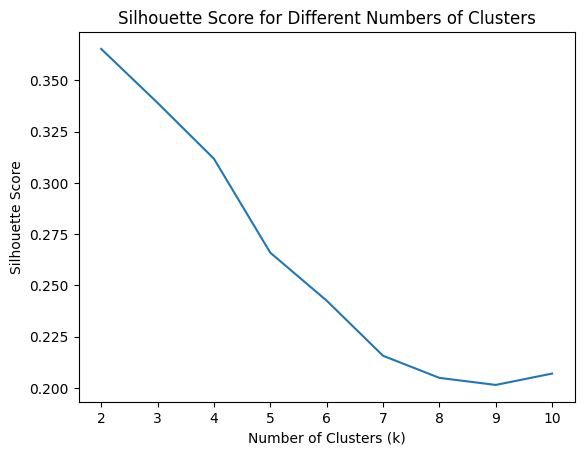

In [60]:
evaluator = ClusteringEvaluator(featuresCol="features", metricName="silhouette", distanceMeasure="squaredEuclidean")

silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(featuresCol="features", k=k, seed=42)
    model = kmeans.fit(df_transformed)
    predictions = model.transform(df_transformed)

    score = evaluator.evaluate(predictions)
    silhouette_scores.append((k, score))

plt.plot([x[0] for x in silhouette_scores], [x[1] for x in silhouette_scores])
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score for Different Numbers of Clusters")

In [61]:
import builtins

best_k = 3
kmeans = KMeans(featuresCol="features", k=best_k, seed=42)
model = kmeans.fit(df_transformed)
clustered_df = model.transform(df_transformed)

In [62]:
clustered_df = clustered_df.withColumnRenamed("prediction", "cluster")
cols_to_drop = [c for c in clustered_df.columns if c.endswith("_index") or c.endswith("_encoded")] + ["numeric_features", "numeric_scaled", "features"]
result_df = clustered_df.drop(*cols_to_drop)

result_df.show()

+---------------+-------------+----+----------+-----------------+---------+----------+----------+--------+-------------+---------------+----------------+------------------------+-------+
|            cif|Jenis_Kelamin|Umur|Range_Umur|Status_Pernikahan|     Gaji|Range_Gaji|Pendidikan|    Kota|Tipe_Customer|jumlah_rekening|jumlah_transaksi|jumlah_nominal_transaksi|cluster|
+---------------+-------------+----+----------+-----------------+---------+----------+----------+--------+-------------+---------------+----------------+------------------------+-------+
|904238687894877|    Perempuan|  28|     25-34|          Married|119927317|    >100Jt|        S1| Jakarta|      Reguler|              1|               6|                31209136|      1|
|110170787245831|    Laki-Laki|  27|     25-34|           Single| 96480811|  50-100Jt|        S1|   Medan|     Priority|              1|               3|                10291007|      1|
|287198831176361|    Laki-Laki|  28|     25-34|           Single|

In [ ]:
pdf = result_df.toPandas()
output_excel = base_path + "/Customer Segmentation Result.xlsx"
pdf.to_excel(output_excel, index=False)